In [0]:
!pip install imbalanced-learn  
!pip install --upgrade numpy scipy threadpoolctl  
!pip install xgboost  
!pip install catboost  
!pip install shap
!pip install lightgbm
!pip install -U xgboost

In [0]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, recall_score, f1_score, cohen_kappa_score
from imblearn.over_sampling import SMOTE
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier  
from catboost import CatBoostClassifier
import numpy as np
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from sklearn.utils.class_weight import compute_sample_weight


# Error Analysis AgeGroup XGBoost

## Visualizing class distribution per AgeGroup

Unique Age Groups in the dataset: ['20-24' '30-34' '40-44' '60-64' '25-29' '50-54' '45-49' '35-39' '55-59'
 'under 20' '65+']


/root/.ipykernel/26953/command-4365819718506033-1556126039:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y["Attrition"] = label_encoder.fit_transform(y["Attrition"])  # "No" = 0, "Yes" = 1


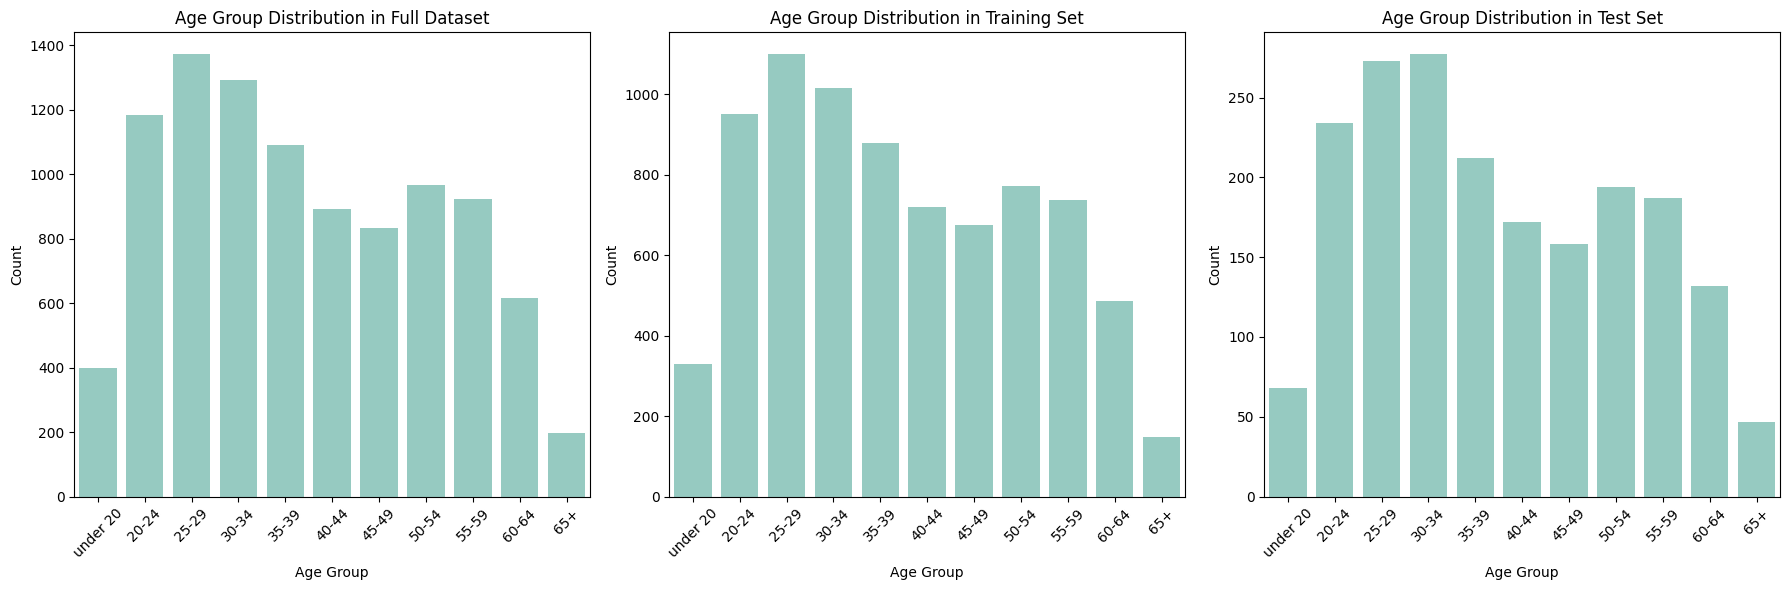


Age Group Distribution in Full Dataset:
AgeGroup
25-29       0.140487
30-34       0.132398
20-24       0.121339
35-39       0.111714
50-54       0.098915
55-59       0.094614
40-44       0.091235
45-49       0.085296
60-64       0.063178
under 20    0.040754
65+         0.020070
Name: proportion, dtype: float64

Age Group Distribution in Training Set:
AgeGroup
25-29       0.140681
30-34       0.130056
20-24       0.121736
35-39       0.112519
50-54       0.098822
55-59       0.094342
40-44       0.092038
45-49       0.086406
60-64       0.062084
under 20    0.042243
65+         0.019073
Name: proportion, dtype: float64

Age Group Distribution in Test Set:
AgeGroup
30-34       0.141760
25-29       0.139713
20-24       0.119754
35-39       0.108495
50-54       0.099284
55-59       0.095701
40-44       0.088025
45-49       0.080860
60-64       0.067554
under 20    0.034800
65+         0.024053
Name: proportion, dtype: float64


In [0]:
# Create a mapping of numeric values to AgeGroup labels
age_group_labels = [
    'under 20',   # 0
    '20-24',      # 1
    '25-29',      # 2
    '30-34',      # 3
    '35-39',      # 4
    '40-44',      # 5
    '45-49',      # 6
    '50-54',      # 7
    '55-59',      # 8
    '60-64',      # 9
    '65+'         # 10
]

# Map the numeric AgeGroup values to the string labels
df_employees_cleaned['AgeGroup'] = df_employees_cleaned['AgeGroup'].map(
    dict(enumerate(age_group_labels))
)

# Now check the unique values again
print("Unique Age Groups in the dataset:", df_employees_cleaned['AgeGroup'].unique())

# Prepare the feature variables (X) and target variable (y)
X = df_employees_cleaned.drop(columns=["Attrition"])  # Features (excluding AgeGroup and Attrition)
y = df_employees_cleaned[["Attrition"]]  # Target: both Attrition and AgeGroup

# Convert the target variable `Attrition` to numeric (0 = "No", 1 = "Yes")
label_encoder = LabelEncoder()
y["Attrition"] = label_encoder.fit_transform(y["Attrition"])  # "No" = 0, "Yes" = 1

# Split the dataset into training and test sets (80% train, 20% test)
# Stratify on both Attrition and AgeGroup
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Plot distributions of AgeGroup for the full dataset, training set, and test set
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Full dataset distribution (using the first color of Set3 palette)
sns.countplot(x=df_employees_cleaned['AgeGroup'], color=sns.color_palette("Set3", n_colors=12)[0], order=age_group_labels, ax=axes[0])
axes[0].set_title('Age Group Distribution in Full Dataset')
axes[0].set_xlabel('Age Group')
axes[0].set_ylabel('Count')

# Training set distribution (using the first color of Set3 palette)
sns.countplot(x=df_employees_cleaned.loc[X_train.index, 'AgeGroup'], color=sns.color_palette("Set3", n_colors=12)[0], order=age_group_labels, ax=axes[1])
axes[1].set_title('Age Group Distribution in Training Set')
axes[1].set_xlabel('Age Group')
axes[1].set_ylabel('Count')

# Test set distribution (using the first color of Set3 palette)
sns.countplot(x=df_employees_cleaned.loc[X_test.index, 'AgeGroup'], color=sns.color_palette("Set3", n_colors=12)[0], order=age_group_labels, ax=axes[2])
axes[2].set_title('Age Group Distribution in Test Set')
axes[2].set_xlabel('Age Group')
axes[2].set_ylabel('Count')

# Rotate the x-axis labels for better readability
for ax in axes:
    ax.tick_params(axis='x', rotation=45)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the plots
plt.show()

# Optional: Compare the proportions numerically
print("\nAge Group Distribution in Full Dataset:")
print(df_employees_cleaned['AgeGroup'].value_counts(normalize=True))

print("\nAge Group Distribution in Training Set:")
print(df_employees_cleaned.loc[X_train.index, 'AgeGroup'].value_counts(normalize=True))

print("\nAge Group Distribution in Test Set:")
print(df_employees_cleaned.loc[X_test.index, 'AgeGroup'].value_counts(normalize=True))






Full Dataset: 9766 rows
Training Set: 7812 rows
Test Set: 1954 rows


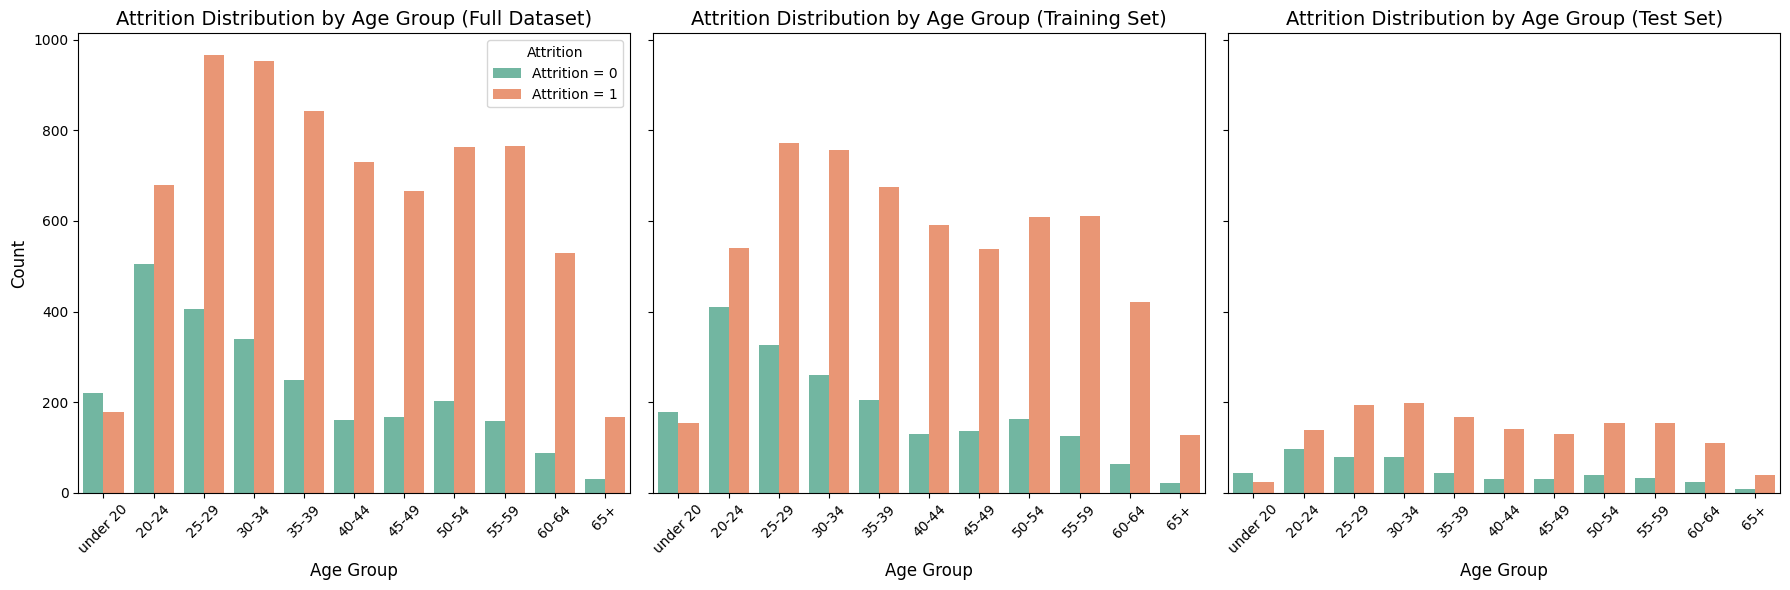

In [0]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Add AgeGroup labels for readability
age_group_labels = [
    'under 20', '20-24', '25-29', '30-34', '35-39',
    '40-44', '45-49', '50-54', '55-59', '60-64', '65+'
]

# Ensure 'AgeGroup' and 'Attrition' exist in all subsets
# Full dataset, training set, and test set
df_full = df_employees_cleaned.reset_index(drop=True)
df_train = df_employees_cleaned.loc[X_train.index].reset_index(drop=True)
df_test = df_employees_cleaned.loc[X_test.index].reset_index(drop=True)

# Verify subsets are populated
print(f"Full Dataset: {len(df_full)} rows")
print(f"Training Set: {len(df_train)} rows")
print(f"Test Set: {len(df_test)} rows")

# Set up the figure and axes
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=True)

# Full dataset plot
sns.countplot(
    x='AgeGroup', hue='Attrition', data=df_full, palette="Set2",
    order=age_group_labels, ax=axes[0]
)
axes[0].set_title('Attrition Distribution by Age Group (Full Dataset)', fontsize=14)
axes[0].set_xlabel('Age Group', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].legend(title='Attrition', labels=['Attrition = 0', 'Attrition = 1'])
axes[0].tick_params(axis='x', rotation=45)

# Training set plot
sns.countplot(
    x='AgeGroup', hue='Attrition', data=df_train, palette="Set2",
    order=age_group_labels, ax=axes[1]
)
axes[1].set_title('Attrition Distribution by Age Group (Training Set)', fontsize=14)
axes[1].set_xlabel('Age Group', fontsize=12)
axes[1].set_ylabel('')
axes[1].legend([], frameon=False)  # Remove redundant legend
axes[1].tick_params(axis='x', rotation=45)

# Test set plot
sns.countplot(
    x='AgeGroup', hue='Attrition', data=df_test, palette="Set2",
    order=age_group_labels, ax=axes[2]
)
axes[2].set_title('Attrition Distribution by Age Group (Test Set)', fontsize=14)
axes[2].set_xlabel('Age Group', fontsize=12)
axes[2].set_ylabel('')
axes[2].legend([], frameon=False)  # Remove redundant legend
axes[2].tick_params(axis='x', rotation=45)

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()


## Error analysis on AgeGroup

In [0]:
# If 'AgeGroup' exists in the dataset, we can evaluate the model performance by age group
if 'AgeGroup' in df_employees_cleaned.columns:
    # Define the AgeGroup labels directly
    age_group_labels = [
        'under 20', '20-24', '25-29', '30-34', '35-39', '40-44', 
        '45-49', '50-54', '55-59', '60-64', '65+'
    ]

    # Create an empty list to store the metrics for each age group
    metrics = []

    # Calculate metrics for each AgeGroup
    for age_group in range(11):  # 0 to 10 representing the 11 age groups
        # Filter the test data by AgeGroup
        age_group_mask = X_test['AgeGroup'] == age_group
        y_test_age_group = y_test[age_group_mask]
        y_test_pred_age_group = y_test_pred_xgb[age_group_mask]  # Filter predictions using the same mask

        # Calculate accuracy, recall, and F1 score for this AgeGroup
        accuracy = accuracy_score(y_test_age_group, y_test_pred_age_group)
        recall = recall_score(y_test_age_group, y_test_pred_age_group, pos_label=1)  # Assuming "Yes" = 1
        f1 = f1_score(y_test_age_group, y_test_pred_age_group, pos_label=1)  # Assuming "Yes" = 1

        # Store the results in the metrics list
        metrics.append({
            'AgeGroup': age_group_labels[age_group],
            'Accuracy': accuracy,
            'Recall': recall,
            'F1 Score': f1
        })

    # Convert the metrics list to a DataFrame
    metrics_df = pd.DataFrame(metrics)

    # Create the plot figure and axes
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    # Accuracy by AgeGroup
    sns.barplot(x='AgeGroup', y='Accuracy', data=metrics_df, ax=axes[0], color=sns.color_palette("Set3")[0])
    axes[0].set_title('Accuracy by Age Group')
    axes[0].set_xlabel('Age Group')
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xticklabels(age_group_labels, rotation=45)
    axes[0].axhline(y=test_accuracy_xgb, color='black', linestyle='--', label=f'Accuracy: {test_accuracy_xgb:.4f}')
    axes[0].legend(loc='lower right', bbox_to_anchor=(1, -0.2), frameon=False)

    # Recall by AgeGroup
    sns.barplot(x='AgeGroup', y='Recall', data=metrics_df, ax=axes[1], color=sns.color_palette("Set3")[0])
    axes[1].set_title('Recall by Age Group')
    axes[1].set_xlabel('Age Group')
    axes[1].set_ylabel('Recall')
    axes[1].set_xticklabels(age_group_labels, rotation=45)
    axes[1].axhline(y=test_recall_xgb, color='black', linestyle='--', label=f'Recall: {test_recall_xgb:.4f}')
    axes[1].legend(loc='lower right', bbox_to_anchor=(1, -0.2), frameon=False)

    # F1 Score by AgeGroup
    sns.barplot(x='AgeGroup', y='F1 Score', data=metrics_df, ax=axes[2], color=sns.color_palette("Set3")[0])
    axes[2].set_title('F1 Score by Age Group')
    axes[2].set_xlabel('Age Group')
    axes[2].set_ylabel('F1 Score')
    axes[2].set_xticklabels(age_group_labels, rotation=45)
    axes[2].axhline(y=test_f1_score_xgb, color='black', linestyle='--', label=f'F1 Score: {test_f1_score_xgb:.4f}')
    axes[2].legend(loc='lower right', bbox_to_anchor=(1, -0.2), frameon=False)

    # Adjust the layout to prevent overlap
    plt.tight_layout()

    # Display the plots
    plt.show()

In [0]:
from sklearn.metrics import recall_score, f1_score, accuracy_score
import pandas as pd

# If 'AgeGroup' exists in the dataset, we can evaluate the model performance by age group
if 'AgeGroup' in df_employees_cleaned.columns:
    # Define the AgeGroup labels directly
    age_group_labels = [
        'under 20', '20-24', '25-29', '30-34', '35-39', '40-44', 
        '45-49', '50-54', '55-59', '60-64', '65+'
    ]

    # Create an empty list to store the metrics for each age group
    metrics = []

    # Calculate metrics for each AgeGroup
    for age_group in range(11):  # 0 to 10 representing the 11 age groups
        # Filter the test data by AgeGroup
        age_group_mask = X_test['AgeGroup'] == age_group
        y_test_age_group = y_test[age_group_mask]
        y_test_pred_age_group = y_test_pred_xgb[age_group_mask]  # Filter predictions using the same mask

        # Calculate accuracy, recall, and F1 score for this AgeGroup
        accuracy = accuracy_score(y_test_age_group, y_test_pred_age_group)
        recall = recall_score(y_test_age_group, y_test_pred_age_group, pos_label=1)  # Assuming "Yes" = 1
        f1 = f1_score(y_test_age_group, y_test_pred_age_group, pos_label=1)  # Assuming "Yes" = 1

        # Store the results in the metrics list
        metrics.append({
            'AgeGroup': age_group_labels[age_group],
            'Accuracy': accuracy,
            'Recall': recall,
            'F1 Score': f1
        })

    # Convert the metrics list to a DataFrame
    metrics_df = pd.DataFrame(metrics)

    # Print the metrics per Age Group
    print("Model Performance by Age Group:")
    print(metrics_df[['AgeGroup', 'Recall', 'F1 Score']].to_string(index=False))


In [0]:

# Define AgeGroup labels
age_group_labels = [
    'under 20', '20-24', '25-29', '30-34', '35-39', '40-44', 
    '45-49', '50-54', '55-59', '60-64', '65+'
]

# Initialize an empty list to store metrics
metrics = []

# Compute metrics for each age group
for age_group in range(11):  # 0 to 10 for each age group
    # Filter test data for the current age group
    age_group_mask = X_test['AgeGroup'] == age_group
    y_test_age_group = y_test[age_group_mask]
    y_test_pred_age_group = y_test_pred_xgb[age_group_mask]
    
    # Calculate metrics
    accuracy = accuracy_score(y_test_age_group, y_test_pred_age_group)
    recall = recall_score(y_test_age_group, y_test_pred_age_group, pos_label=1)  # Assuming "Yes" = 1
    f1 = f1_score(y_test_age_group, y_test_pred_age_group, pos_label=1)  # Assuming "Yes" = 1

    # Append results to the metrics list
    metrics.append({
        'AgeGroup': age_group_labels[age_group],
        'Accuracy': round(accuracy, 4),
        'Recall': round(recall, 4),
        'F1 Score': round(f1, 4)
    })

# Convert the metrics list to a DataFrame for better visualization
metrics_df = pd.DataFrame(metrics)

# Display the DataFrame as a table
print("\nPerformance Metrics by Age Group:")
print(metrics_df)

## Feature importances per AgeGroup

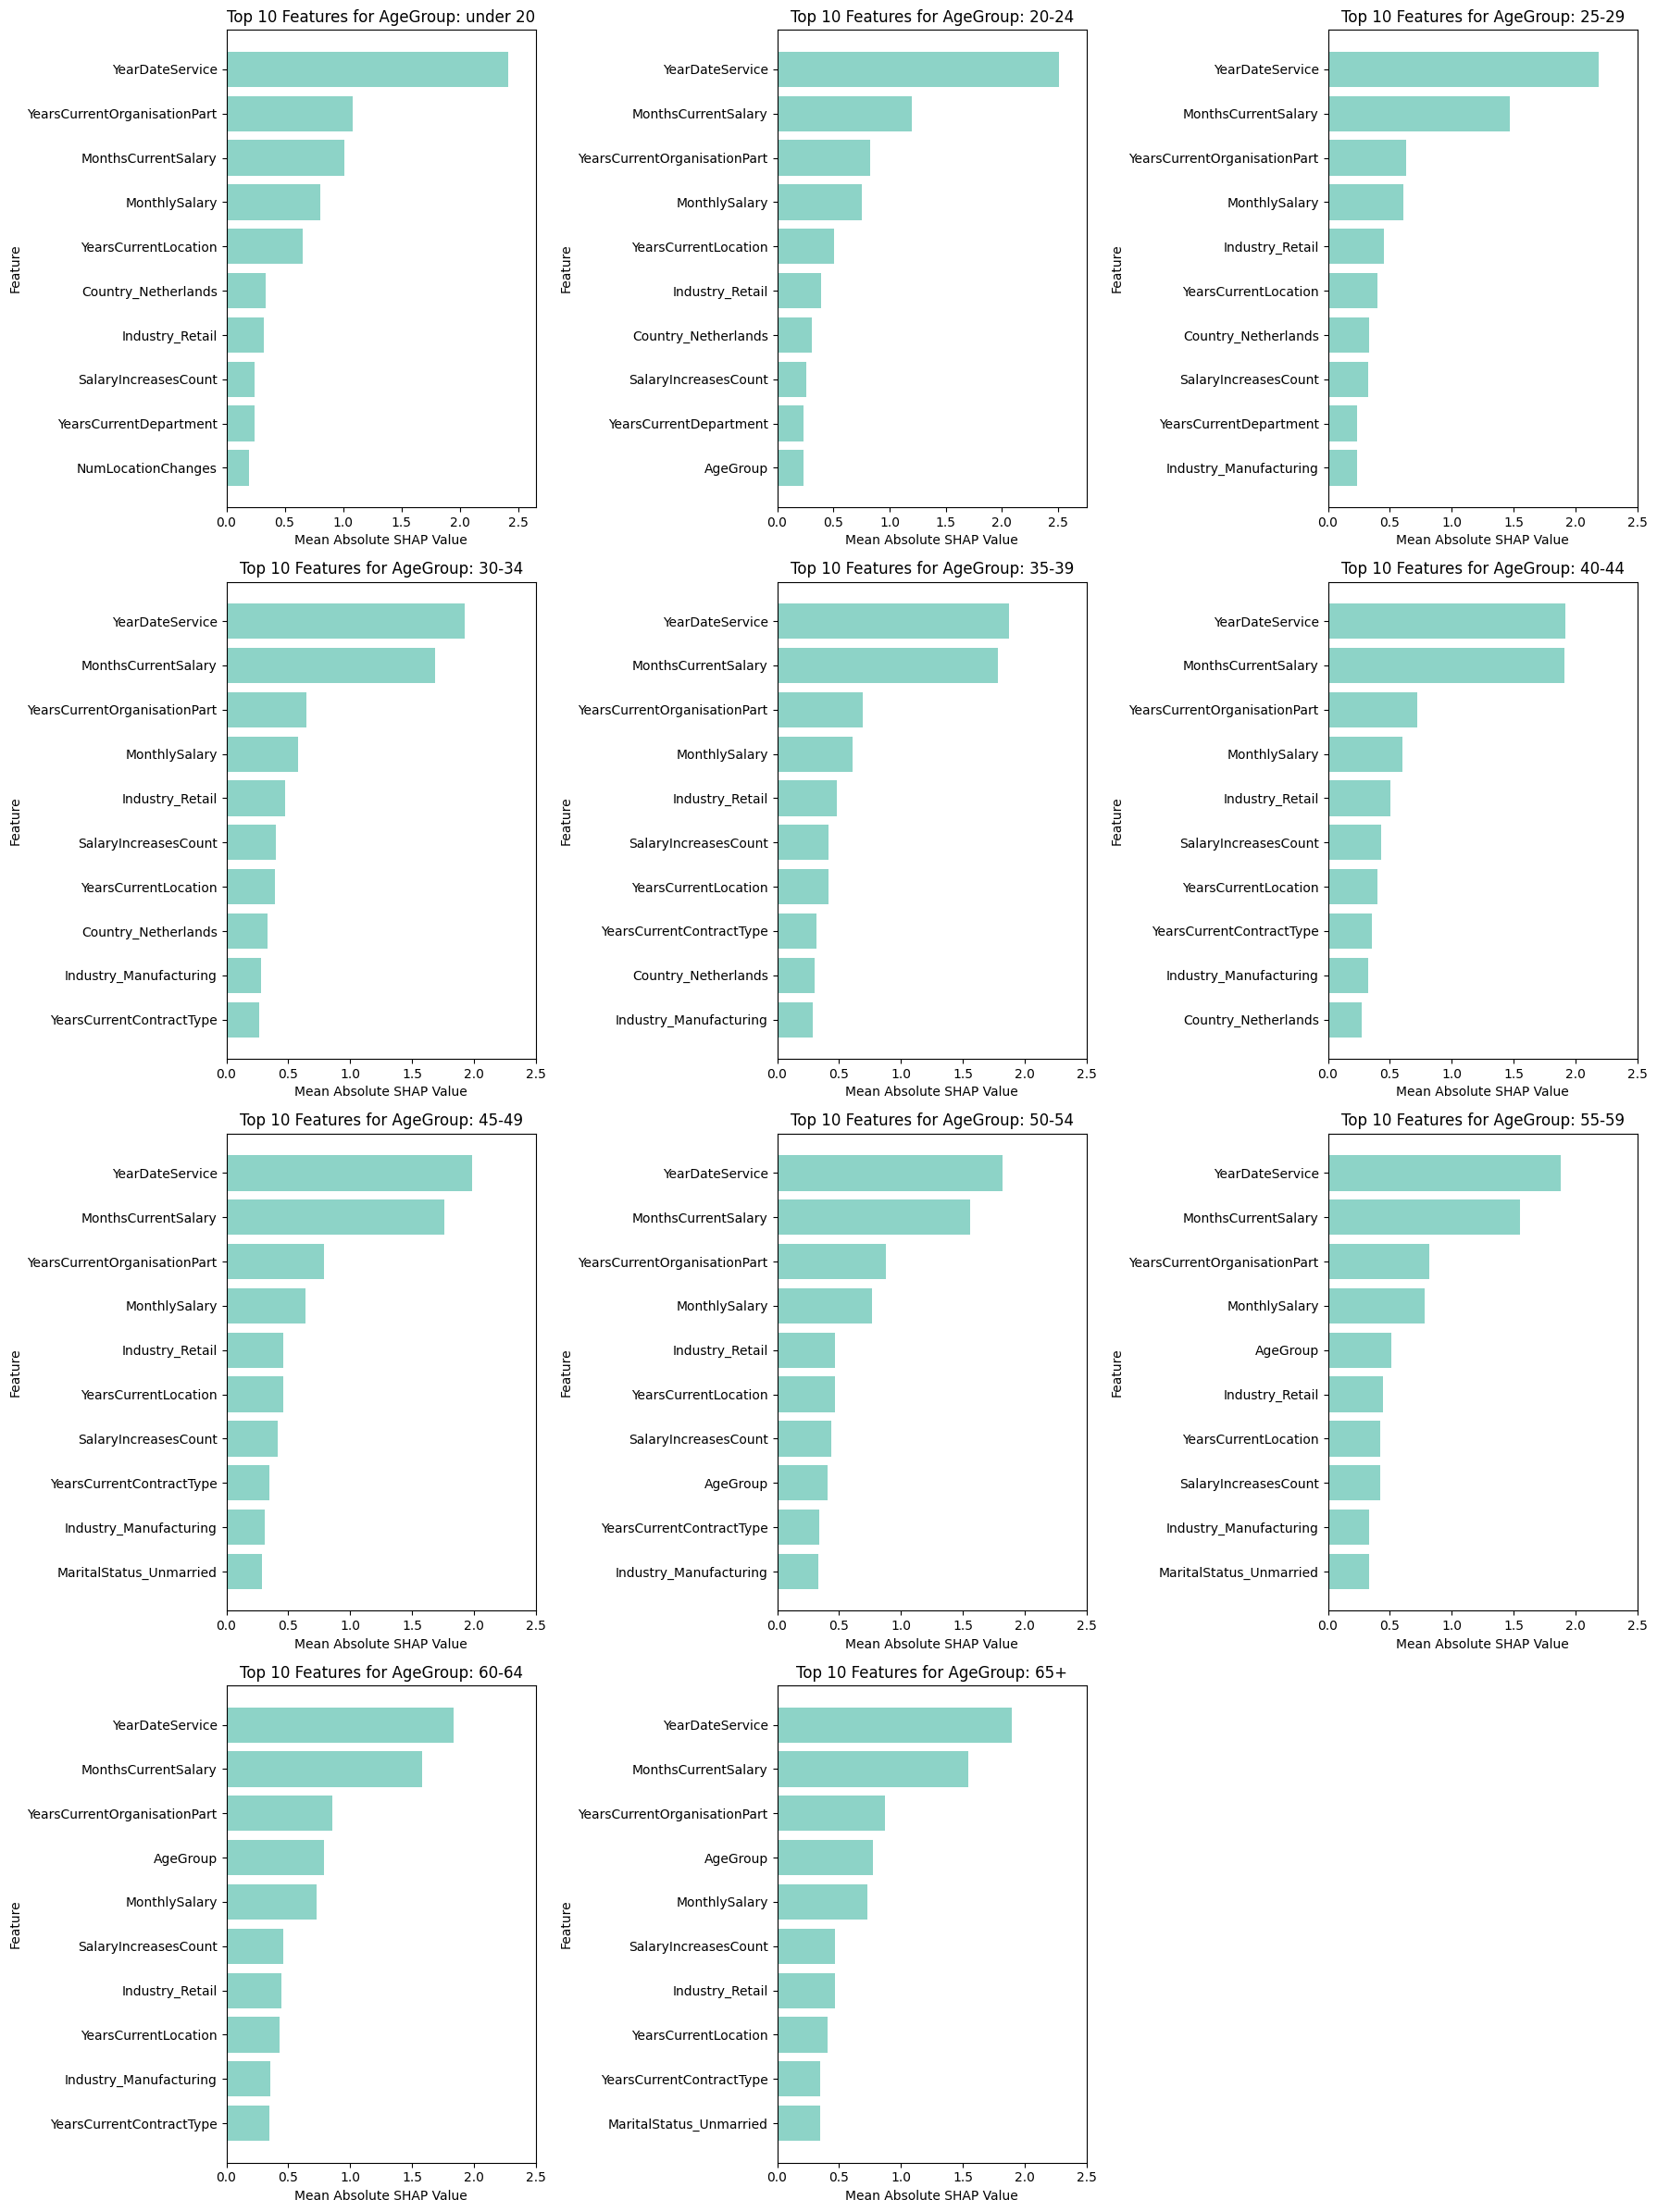

In [0]:
# Create a SHAP explainer for the XGBoost model
explainer = shap.Explainer(final_xgb_classifier)

# Create a mapping of numeric values to AgeGroup labels
age_group_labels = [
    'under 20',   # 0
    '20-24',      # 1
    '25-29',      # 2
    '30-34',      # 3
    '35-39',      # 4
    '40-44',      # 5
    '45-49',      # 6
    '50-54',      # 7
    '55-59',      # 8
    '60-64',      # 9
    '65+'         # 10
]

# Get the unique AgeGroups in the training set
age_groups = np.unique(X_train['AgeGroup'].values)

# Ensure the mapping from numeric to label is correct
age_group_mapping = {i: label for i, label in enumerate(age_group_labels)}

# Calculate the number of rows and columns needed for subplots (3 plots per row)
num_cols = 3
num_rows = (len(age_groups) + num_cols - 1) // num_cols  # Adjust rows to fit all age groups

# Create a subplot with 3 graphs per row (avoiding extra empty plots)
fig, axes = plt.subplots(num_rows, num_cols, figsize=(18, 6 * num_rows))

# Flatten the axes array to easily iterate over it
axes = axes.flatten()

# Loop over each AgeGroup and compute mean absolute SHAP values for feature importance
for idx, age_group in enumerate(age_groups):
    # Filter data for the current AgeGroup
    group_data = X_train[X_train['AgeGroup'] == age_group]
    
    # Compute SHAP values for the current group
    shap_values = explainer(group_data)
    
    # Get mean absolute SHAP values for each feature
    mean_abs_shap_values = np.abs(shap_values.values).mean(axis=0)
    
    # Create a DataFrame of feature names and their mean absolute SHAP values
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Mean Abs SHAP Value': mean_abs_shap_values
    })
    
    # Sort the features by mean absolute SHAP value in descending order
    feature_importance = feature_importance.sort_values(by='Mean Abs SHAP Value', ascending=False)
    
    # Keep only the top 10 features
    top_10_features = feature_importance.head(10)
    
    # Plot the feature importance on the corresponding subplot
    axes[idx].barh(top_10_features['Feature'], top_10_features['Mean Abs SHAP Value'], color=sns.color_palette("Set3")[0])
    axes[idx].set_title(f"Top 10 Features for AgeGroup: {age_group_mapping[age_group]}")
    axes[idx].set_xlabel("Mean Absolute SHAP Value")
    axes[idx].set_ylabel("Feature")
    axes[idx].invert_yaxis()  # Invert y-axis for better readability
    
    # Set the x-axis limits to extend just beyond the largest value (up to 2.5)
    max_shap_value = top_10_features['Mean Abs SHAP Value'].max()
    axes[idx].set_xlim(0, max(2.5, max_shap_value * 1.1))  # Extend a bit beyond the largest SHAP value

# Hide any remaining empty axes
for idx in range(len(age_groups), len(axes)):
    axes[idx].axis('off')  # Hide empty subplots

# Adjust layout to ensure plots fit well
plt.tight_layout()

# Show the plots
plt.show()





